# Drought analysis

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

In [3]:
# For MEV
from scipy.stats import genextreme, gumbel_r, weibull_min

In [5]:
# Import drought classification functions
from critical_days_module import droughts, classify_discharge_status

Exported functions to: critical_days_module.py


In [6]:
# Load Data
#simulated
historic = pd.read_csv("Historic_discharge.csv", parse_dates=["date"], index_col="date")
future = pd.read_csv("Future_scenarios_discharge.csv", parse_dates=["date"], index_col="date")

#observed
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Observed")
xr_observed = xr.Dataset({"Observed": ("time", discharge_series.values)}, coords={"time": discharge_series.index})


In [7]:
# Convert to xarray for CDF function
def df_to_xarray(df):
    return xr.Dataset({col: ("time", df[col].values) for col in df.columns}, coords={"time": df.index})

xr_historic = df_to_xarray(historic)
xr_future = df_to_xarray(future)

In [8]:
# Plot CDF function

def plot_cdf(ds):
    """
    plot cdf for all data variables 

    Parameters:
    - ds: xarray.Dataset
    Returns:
    - nothing
    """
    valid_ds = ds.dropna(dim="time")
    sorted_vars = {
        name: np.sort(valid_ds[name].values)[::-1]
        for name in valid_ds.data_vars
    }
    n = len(valid_ds.time)
    cdf_index = np.linspace(0, 1, n)
    return_period_days = np.linspace(n, 1, n)
    return_period_years = return_period_days / 365.25

    cdf_ds = xr.Dataset(
        {name: ("cdf", sorted_vars[name]) for name in sorted_vars},
        coords={
            "cdf": cdf_index,
            "return_period": ("cdf", return_period_years)
        }
    )

    # Cumulative Probability plot
    plt.figure(figsize=(10, 6))
    for name in cdf_ds.data_vars:
        plt.plot(cdf_ds.cdf, cdf_ds[name], label=name)
    plt.xlabel("Cumulative Probability")
    plt.ylabel("Discharge (m³/s)")
    plt.title("Empirical CDFs of Discharge Data")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return Period plot (log-log)
    plt.figure(figsize=(10, 6))
    for name in cdf_ds.data_vars:
        plt.plot(cdf_ds.return_period, cdf_ds[name], label=name)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Discharge (m³/s)")
    plt.title("Return Period Plot of Discharge Data (Log-Log Scale)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

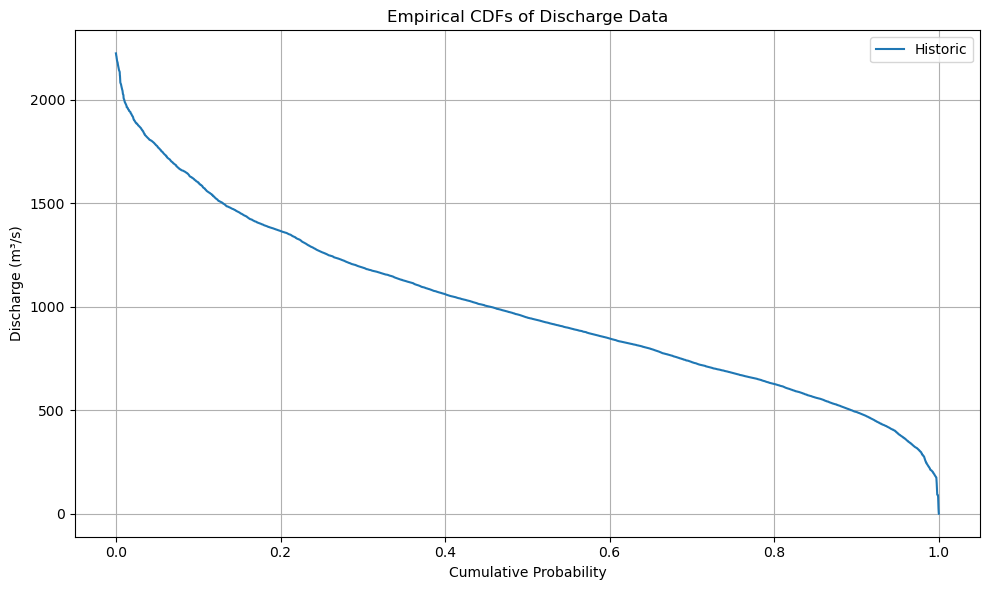

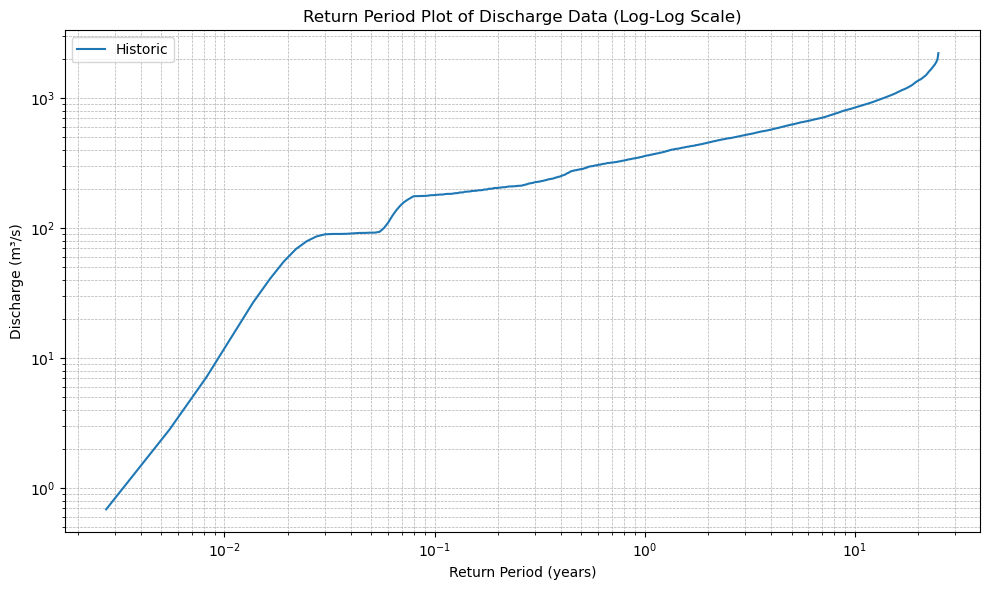

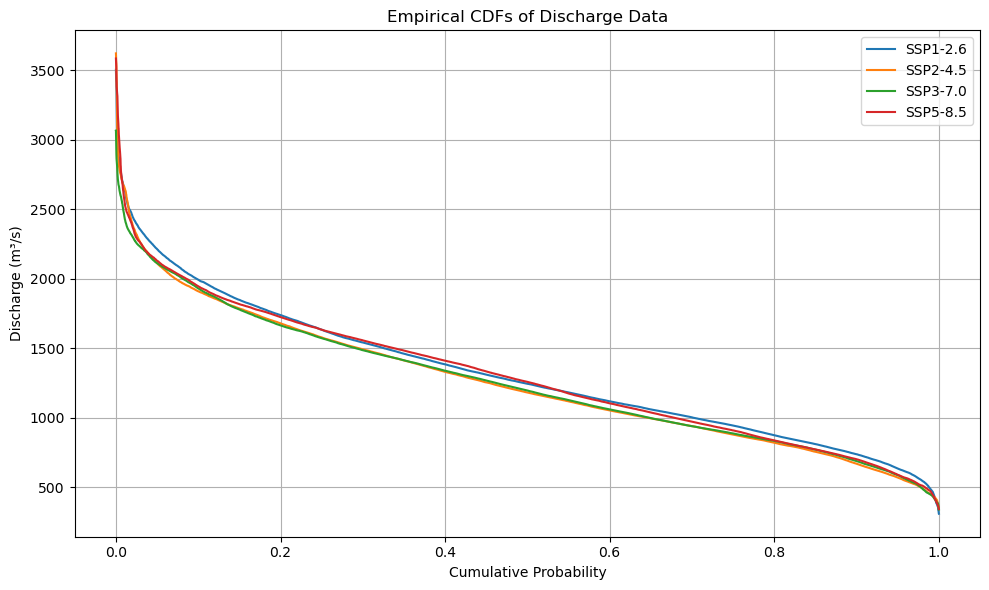

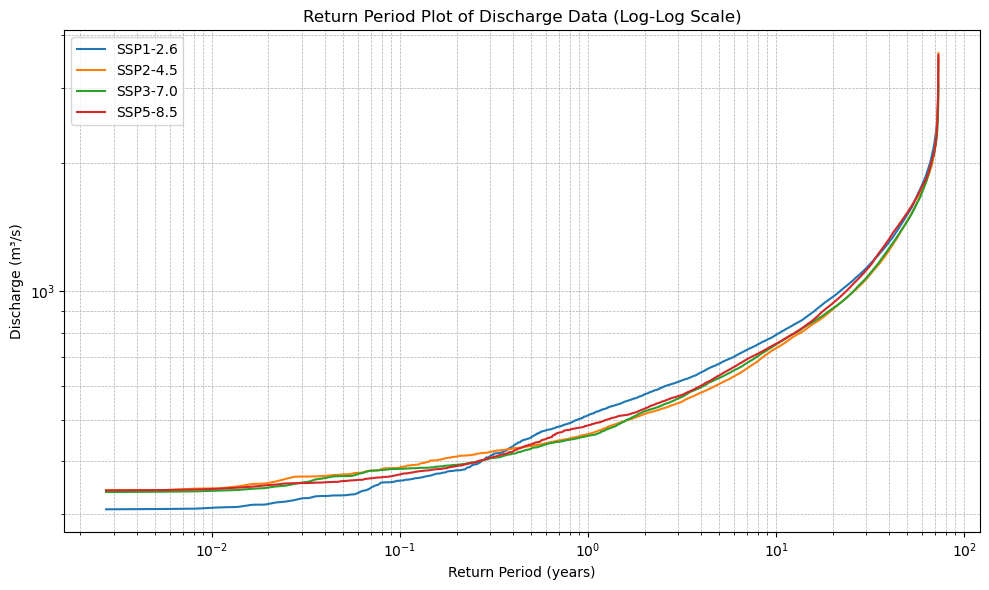

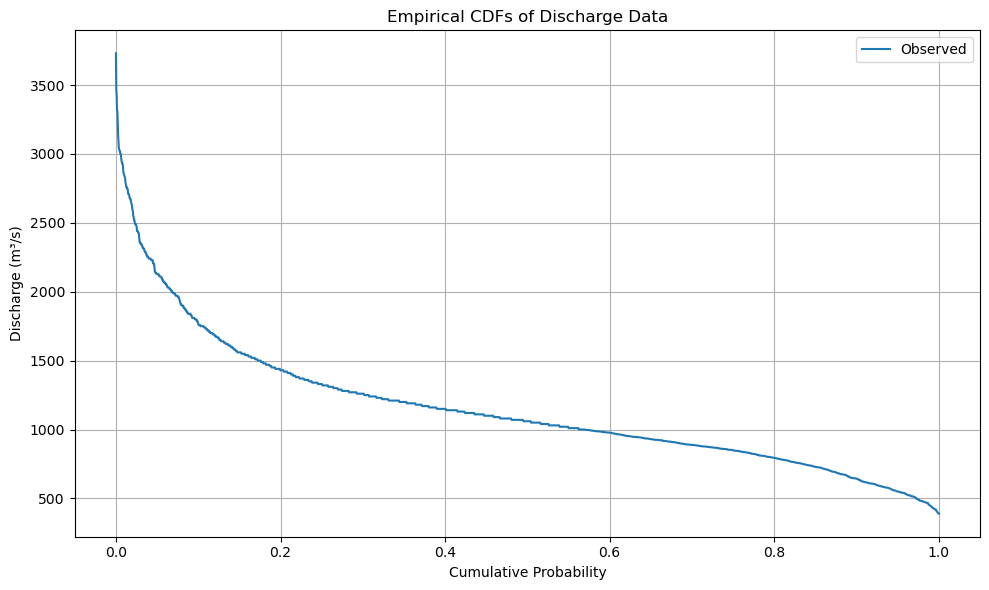

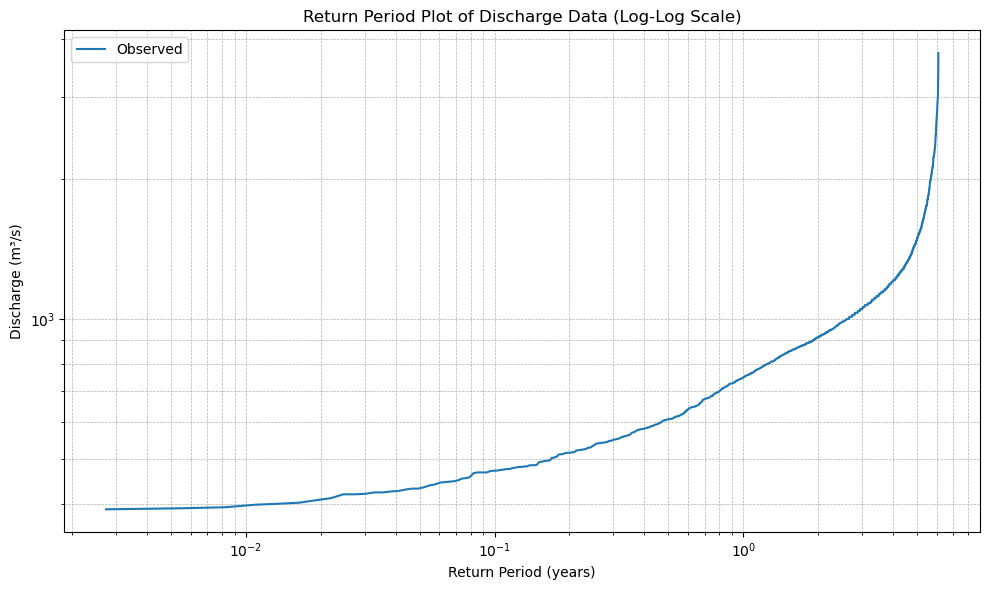

In [9]:
# Call CDF plots
plot_cdf(xr_historic)
plot_cdf(xr_future)
plot_cdf(xr_observed)

In [10]:
# MEV functions
def calculate_mev(ds, dist_type='gev'):
    valid_ds = ds.dropna(dim="time", how="any")
    time_years = pd.to_datetime(valid_ds['time'].values).year
    years = np.unique(time_years)
    mev_distributions = {}

    for var in ds.data_vars:
        annual_params = []
        for year in years:
            mask = time_years == year
            values = valid_ds[var].values[mask]
            if len(values) > 0:
                if dist_type == 'gev':
                    params = genextreme.fit(values)
                    dist_func = genextreme
                elif dist_type == 'gumbel':
                    params = gumbel_r.fit(values)
                    dist_func = gumbel_r
                elif dist_type == 'weibull':
                    params = weibull_min.fit(values)
                    dist_func = weibull_min
                else:
                    raise ValueError("dist_type must be one of ['gev', 'gumbel', 'weibull']")
                annual_params.append(params)

        x_vals = np.linspace(np.min(valid_ds[var]), np.max(valid_ds[var]), 1000)
        cdfs = [dist_func.cdf(x_vals, *params) for params in annual_params]
        mean_cdf = np.mean(cdfs, axis=0)
        return_period = 1 / (1 - mean_cdf)

        mev_distributions[var] = (x_vals, return_period)

    mev_ds = xr.Dataset(
        {var: ("x", mev_distributions[var][1]) for var in mev_distributions},
        coords={"x": list(mev_distributions.values())[0][0]},
        attrs=ds.attrs
    )
    return mev_ds

In [11]:
def plot_mev(*mev_datasets, dist_type='gev', labels=None):
    plt.figure(figsize=(10, 6))
    for i, mev_ds in enumerate(mev_datasets):
        prefix = f"{labels[i]} - " if labels else ""
        for var in mev_ds.data_vars:
            plt.plot(mev_ds[var].values, mev_ds['x'].values, label=f"{prefix}{var}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Discharge (mm/d)")
    plt.title(f"Metastatistical Extreme Value (MEV) Estimates - {dist_type.upper()} Fit")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

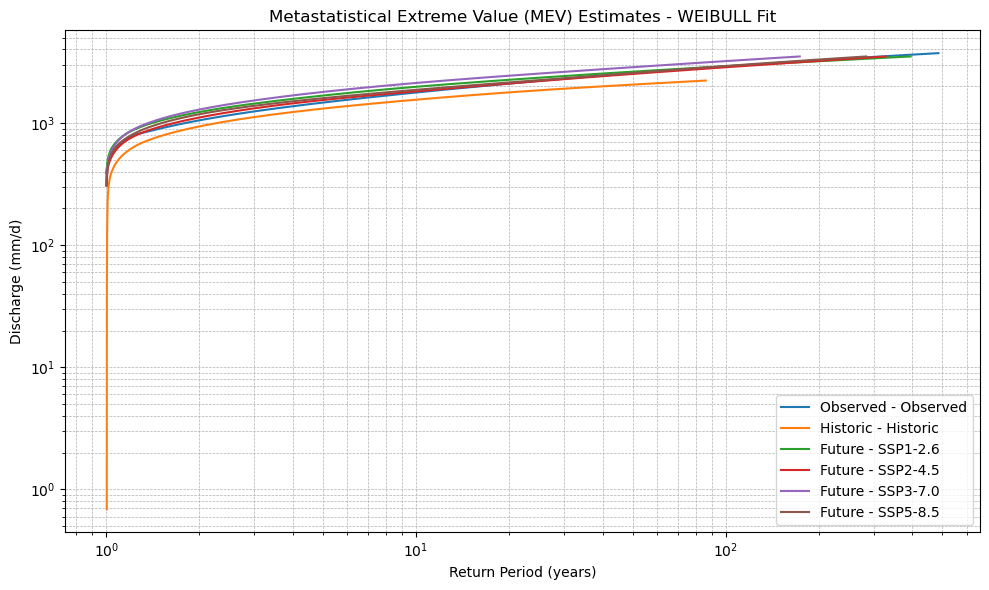

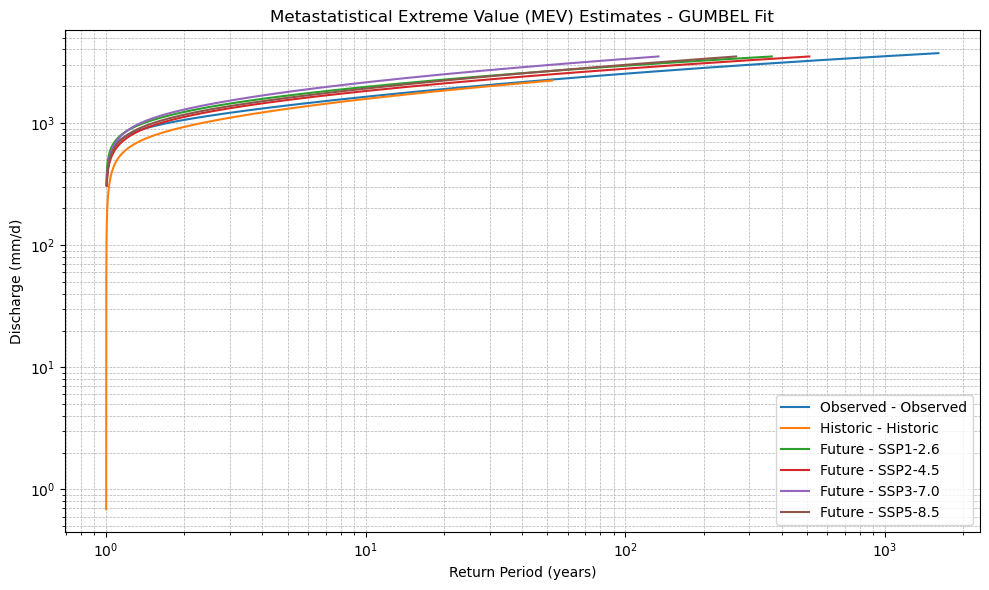

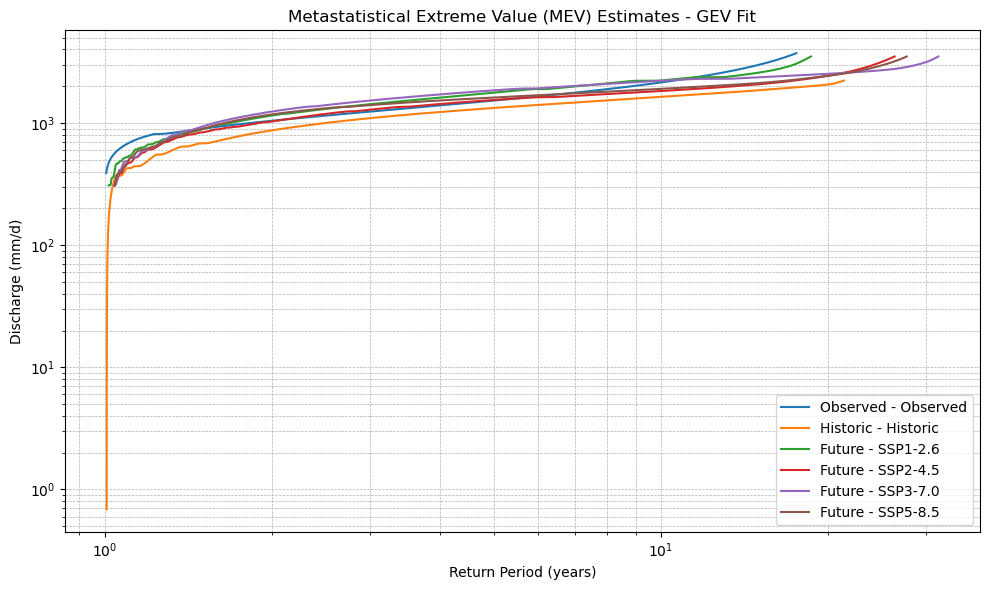

In [12]:
# Run MEV Analysis and Plot for all distributions
for dist in ['weibull', 'gumbel', 'gev']:
    xr_mev_obs = calculate_mev(xr_observed, dist_type=dist)
    xr_mev_hist = calculate_mev(xr_historic, dist_type=dist)
    xr_mev_fut = calculate_mev(xr_future, dist_type=dist)
    plot_mev(xr_mev_obs, xr_mev_hist, xr_mev_fut, dist_type=dist, labels=['Observed', 'Historic', 'Future'])


## Drought return periods by scenario

In [13]:
# Prepare scenarios dictionary with observed included
scenarios = {
    "Observed": discharge_series,
    "Historic": historic.iloc[:, 0],
    "SSP1-2.6": future.iloc[:, 0],
    "SSP2-4.5": future.iloc[:, 1],
    "SSP3-7.0": future.iloc[:, 2],
    "SSP5-8.5": future.iloc[:, 3]
}

# Compute classification counts for each scenario
classification_counts = {}
for name, series in scenarios.items():
    classification = classify_discharge_status(series)
    classification_counts[name] = {
        "caution": classification.count("caution"),
        "risk": classification.count("risk"),
        "critical": classification.count("critical")
    }

In [14]:
# Return period classification from drought category counts (using data from CMIP runs (historic and future) and observed data)
def compute_return_period_classification(counts, total_days):
    return {level: round(total_days / count, 1) if count > 0 else float('inf')
            for level, count in counts.items() if level in ['caution', 'risk', 'critical']}

# Assume 'classification_counts' and 'scenarios' dicts include 'Observed'
# Example usage assumes classification_counts and scenarios have same keys
# including 'Observed', 'Historic', 'SSP2-2.6', etc.
total_days = {name: len(series) for name, series in scenarios.items()}

return_periods = {
    level: {
        scen: compute_return_period_classification(classification_counts[scen], total_days[scen]).get(level, float('inf'))
        for scen in scenarios
    }
    for level in ['caution', 'risk', 'critical']
}

rp_df = pd.DataFrame(return_periods).T


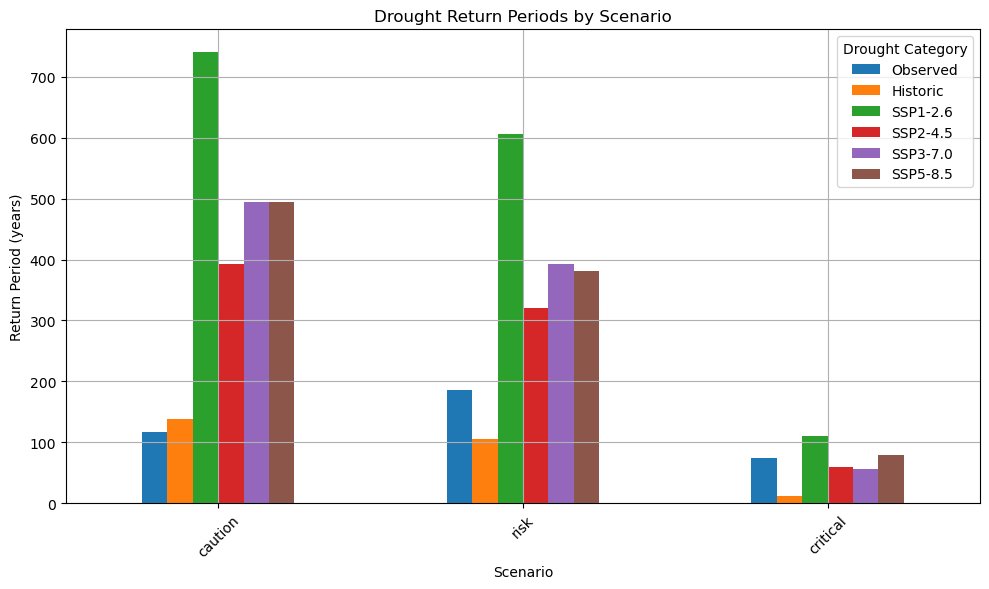

In [15]:
# Plot return periods
fig, ax = plt.subplots(figsize=(10, 6))
rp_df.plot(kind="bar", ax=ax)
ax.set_title("Drought Return Periods by Scenario")
ax.set_ylabel("Return Period (years)")
ax.set_xlabel("Scenario")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Drought Category")
plt.show()

## Drought return periods MEV, Weibull fit

In [16]:
# Use MEV Weibull return period data to classify droughts
xr_mev_obs = calculate_mev(xr_observed, dist_type='weibull')
xr_mev_hist = calculate_mev(xr_historic, dist_type='weibull')
xr_mev_ssp126 = calculate_mev(xr.Dataset({"SSP2-2.6": ("time", future.iloc[:, 0].values)}, coords={"time": pd.to_datetime(future.index)}), dist_type='weibull')
xr_mev_ssp245 = calculate_mev(xr.Dataset({"SSP2-4.5": ("time", future.iloc[:, 1].values)}, coords={"time": pd.to_datetime(future.index)}), dist_type='weibull')
xr_mev_ssp370 = calculate_mev(xr.Dataset({"SSP3-7.0": ("time", future.iloc[:, 2].values)}, coords={"time": pd.to_datetime(future.index)}), dist_type='weibull')
xr_mev_ssp585 = calculate_mev(xr.Dataset({"SSP5-8.5": ("time", future.iloc[:, 3].values)}, coords={"time": pd.to_datetime(future.index)}), dist_type='weibull')

mev_scenarios = {
    "Observed": xr_mev_obs,
    "Historic": xr_mev_hist,
    "SSP1-2.6": xr_mev_ssp126,
    "SSP2-4.5": xr_mev_ssp245,
    "SSP3-7.0": xr_mev_ssp370,
    "SSP5-8.5": xr_mev_ssp585
}

def categorize_mev_droughts(xr_mev):
    """Categorize discharge values from MEV output using classify_discharge_status."""
    var = list(xr_mev.data_vars)[0]
    discharge_values = xr_mev['x'].values
    status = classify_discharge_status(discharge_values)
    rp = xr_mev[var].values
    return pd.DataFrame({'Discharge': discharge_values, 'ReturnPeriod': rp, 'Category': status})

mev_obs_classified = categorize_mev_droughts(xr_mev_obs)
mev_hist_classified = categorize_mev_droughts(xr_mev_hist)


In [17]:
# Count categories
def count_drought_categories(classified_df):
    return classified_df['Category'].value_counts().reindex(['caution', 'risk', 'critical'], fill_value=0)

counts_obs = count_drought_categories(mev_obs_classified)
counts_hist = count_drought_categories(mev_hist_classified)


In [18]:
# Compute classification counts for each MEV scenario
mev_classification_counts = {}

for name, xr_mev in mev_scenarios.items():
    var = list(xr_mev.data_vars)[0]
    rp = xr_mev[var].values
    categorized = []
    for r in rp:
        if r < 2:
            categorized.append("critical")
        elif r < 5:
            categorized.append("risk")
        elif r < 10:
            categorized.append("caution")
        else:
            categorized.append("normal")
    # Count categories
    counts = pd.Series(categorized).value_counts()
    mev_classification_counts[name] = {
        "caution": counts.get("caution", 0),
        "risk": counts.get("risk", 0),
        "critical": counts.get("critical", 0)
    }

# Calculate return periods
mev_total = {name: len(categorized) for name, ds in mev_scenarios.items()}

mev_return_periods = {
    level: {
        scen: compute_return_period_classification(mev_classification_counts[scen], mev_total[scen]).get(level, float('inf'))
        for scen in mev_scenarios
    }
    for level in ['caution', 'risk', 'critical']
}

rp_mev_df = pd.DataFrame(mev_return_periods).T

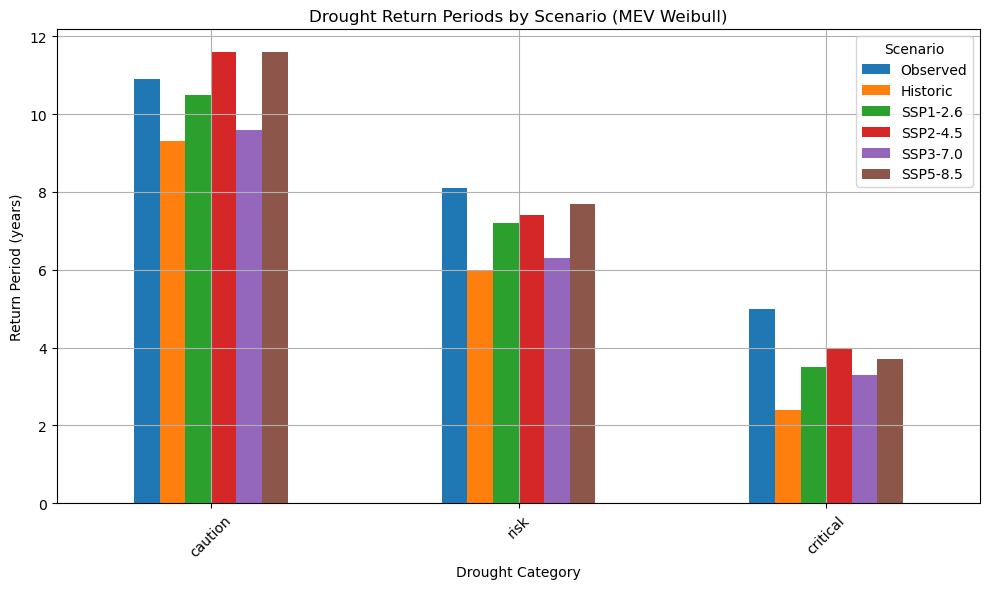

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
rp_mev_df.plot(kind="bar", ax=ax)
ax.set_title("Drought Return Periods by Scenario (MEV Weibull)")
ax.set_ylabel("Return Period (years)")
ax.set_xlabel("Drought Category")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Scenario")
plt.show()


## Number of drought events bij scenario

In [20]:
# Categorize droughts and summarize deficits
def categorize_droughts(scenarios_dict):
    scenario_droughts = {}
    for name, series in scenarios_dict.items():
        status = classify_discharge_status(series)
        droughts_by_status = {"caution": [], "risk": [], "critical": []}
        start = None
        prev = "normal"
        for t, s in zip(series.index, status):
            if s in droughts_by_status:
                if prev != s:
                    if start is not None and prev in droughts_by_status:
                        droughts_by_status[prev].append(series.loc[start:t])
                    start = t
                prev = s
            else:
                if prev in droughts_by_status and start is not None:
                    droughts_by_status[prev].append(series.loc[start:t])
                    start = None
                prev = "normal"
        if start is not None and prev in droughts_by_status:
            droughts_by_status[prev].append(series.loc[start:])

        scenario_droughts[name] = {
            cat: len(periods) for cat, periods in droughts_by_status.items()
        }
    return scenario_droughts

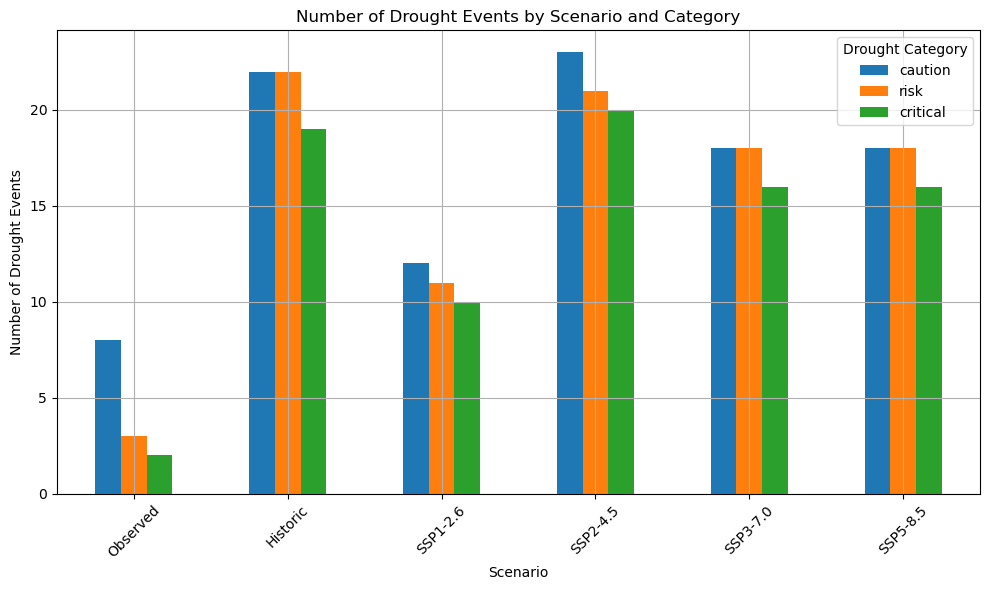

In [21]:
# Apply to all scenarios
drought_df = pd.DataFrame(categorize_droughts(scenarios)).T

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
drought_df.plot(kind='bar', ax=ax)
ax.set_title("Number of Drought Events by Scenario and Category")
ax.set_xlabel("Scenario")
ax.set_ylabel("Number of Drought Events")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Drought Category")
plt.show()
